In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import glob
import os
from torchviz import make_dot



In [3]:
tac_files = glob.glob("clean_tac/*.csv")
tac_data = {}

for file in tac_files:
    pid = os.path.basename(file).split(".")[0]  # Extract participant ID from filename
    df_tac = pd.read_csv(file)
    df_tac['pid'] = pid  # Add participant id as a new column
    tac_data[pid] = df_tac

# Combine all dataframes into a single dataframe
tac_df = pd.concat(tac_data.values(), ignore_index=True)

# Display the first few rows of the combined dataframe
tac_df['timestamp'] = pd.to_datetime(tac_df['timestamp'], unit='ms')


In [4]:
tac_df['timestamp'] = tac_df['timestamp'].astype(int) / 10**9  # Convert to secondtac_data = {}


In [5]:
# Normalize TAC_Reading
scaler = MinMaxScaler()
tac_df['TAC_Reading'] = scaler.fit_transform(tac_df[['TAC_Reading']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_length = 10  # Number of time steps to look back
X, y = create_sequences(tac_df['TAC_Reading'].values, seq_length)
X = X.unsqueeze(2)  # Reshape for LSTM


/var/folders/g_/88s36jhd2rgg_52ddbvx62p00000gn/T/ipykernel_58565/2330220713.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [6]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_size=1, hidden_size=100)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
epochs = 150
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.unsqueeze(1))
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')

# Make predictions
model.eval()
y_pred = model(X_test).detach().numpy()
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))



Epoch 1/150, Loss: 0.079952
Epoch 2/150, Loss: 0.068411
Epoch 3/150, Loss: 0.059168
Epoch 4/150, Loss: 0.052166
Epoch 5/150, Loss: 0.047842
Epoch 6/150, Loss: 0.047093
Epoch 7/150, Loss: 0.049752
Epoch 8/150, Loss: 0.051567
Epoch 9/150, Loss: 0.050795
Epoch 10/150, Loss: 0.048930
Epoch 11/150, Loss: 0.047326
Epoch 12/150, Loss: 0.046460
Epoch 13/150, Loss: 0.046248
Epoch 14/150, Loss: 0.046420
Epoch 15/150, Loss: 0.046712
Epoch 16/150, Loss: 0.046937
Epoch 17/150, Loss: 0.046992
Epoch 18/150, Loss: 0.046842
Epoch 19/150, Loss: 0.046500
Epoch 20/150, Loss: 0.046010
Epoch 21/150, Loss: 0.045433
Epoch 22/150, Loss: 0.044841
Epoch 23/150, Loss: 0.044306
Epoch 24/150, Loss: 0.043886
Epoch 25/150, Loss: 0.043597
Epoch 26/150, Loss: 0.043378
Epoch 27/150, Loss: 0.043082
Epoch 28/150, Loss: 0.042545
Epoch 29/150, Loss: 0.041706
Epoch 30/150, Loss: 0.040656
Epoch 31/150, Loss: 0.039562
Epoch 32/150, Loss: 0.038545
Epoch 33/150, Loss: 0.037606
Epoch 34/150, Loss: 0.036643
Epoch 35/150, Loss: 0.0

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

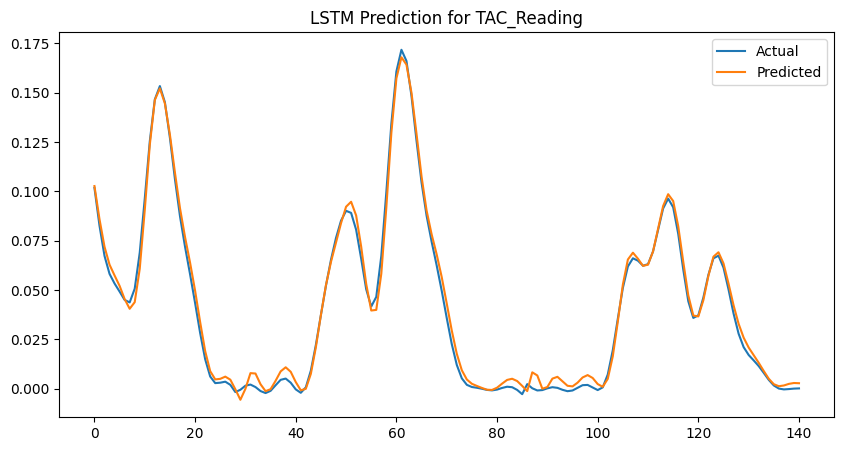

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM Prediction for TAC_Reading')
plt.show()

In [14]:
# Assuming X_train is your data with shape [564, 10, 1]
X_train = X_train.float()  # Ensure the data is in float format

# Make sure the input has the shape (batch_size, sequence_length, input_size)
print(X_train.shape)  # Should print torch.Size([564, 10, 1])

# Pass a single sample through the model to generate output
output = model(X_train)


torch.Size([564, 10, 1])


In [16]:
output = model(X_train)  # Perform forward pass
print("Output shape: ", output.shape)  # Should print something like torch.Size([564, 1])


Output shape:  torch.Size([564, 1])


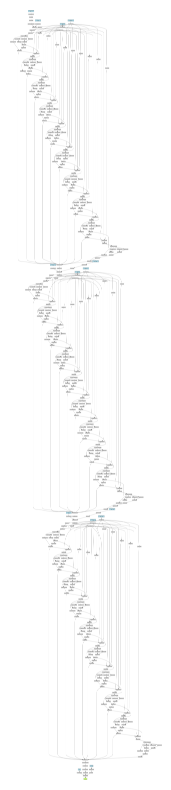

In [17]:
from torchviz import make_dot

# Generate the computational graph
dot = make_dot(output, params=dict(model.named_parameters()))

# Save the graph to a PNG file
dot.format = 'png'
dot.render("lstm_computational_graph")

# Optionally, display the graph inside the notebook
import matplotlib.pyplot as plt
img = plt.imread("lstm_computational_graph.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


/var/folders/g_/88s36jhd2rgg_52ddbvx62p00000gn/T/ipykernel_40683/4024552519.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)


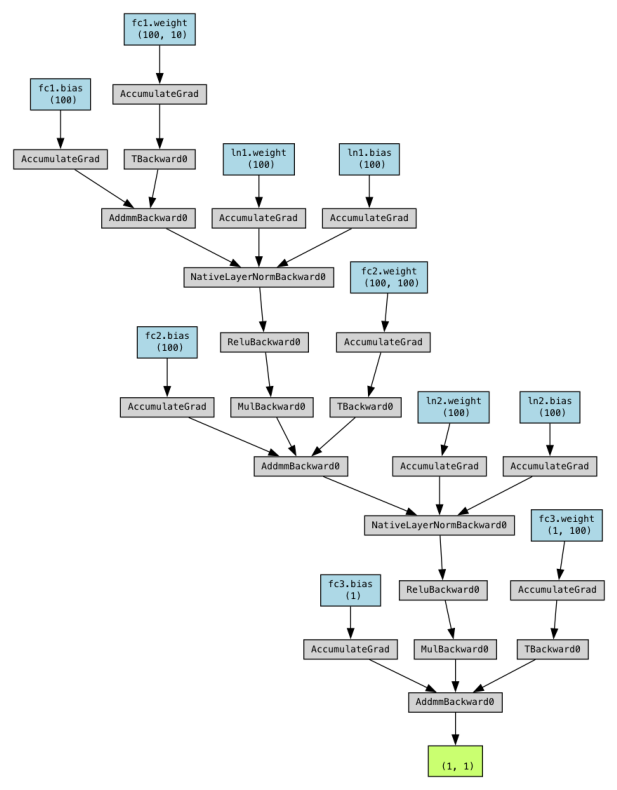

Visualization saved as 'advanced_fnn_model_with_real_data.png'.


In [39]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchviz import make_dot
from sklearn.preprocessing import MinMaxScaler

# Define the Model with Layer Normalization (instead of Batch Normalization)
class AdvancedFNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100):
        super(AdvancedFNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.fc3 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% chance of setting the neuron to zero
    
    def forward(self, x):
        x = torch.relu(self.ln1(self.fc1(x)))  # Apply ReLU activation and Layer Normalization
        x = self.dropout(x)  # Apply Dropout after the first layer
        x = torch.relu(self.ln2(self.fc2(x)))  # Apply ReLU activation and Layer Normalization
        x = self.dropout(x)  # Apply Dropout after the second layer
        x = self.fc3(x)  # Output layer (no activation for regression)
        return x

# Assuming you have already normalized the data and have X_train and y_train

# Example: X_train is of shape (batch_size, num_features)
# You should flatten the data to match the input size for a fully connected network
X_train_flat = X_train.view(X_train.shape[0], -1)  # Flattening the sequence data

# Convert to tensor
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)

# Initialize the model
model = AdvancedFNNModel(input_size=X_train_tensor.shape[1], hidden_size=100)

# Perform a forward pass with the actual training data (first sample for simplicity)
output = model(X_train_tensor[0].unsqueeze(0))  # Unsqueeze to add batch dimension

# Generate the computational graph using torchviz
dot = make_dot(output, params=dict(model.named_parameters()))

# Save the visualization as PNG
dot.format = 'png'
dot.render("advanced_fnn_model_with_real_data")

# Optionally, display the graph within the notebook using matplotlib
img = plt.imread("advanced_fnn_model_with_real_data.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

print("Visualization saved as 'advanced_fnn_model_with_real_data.png'.")
